1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator, UnivariateSpline
from scipy.optimize import curve_fit, minimize
from scipy.fftpack import ifft2, fft2


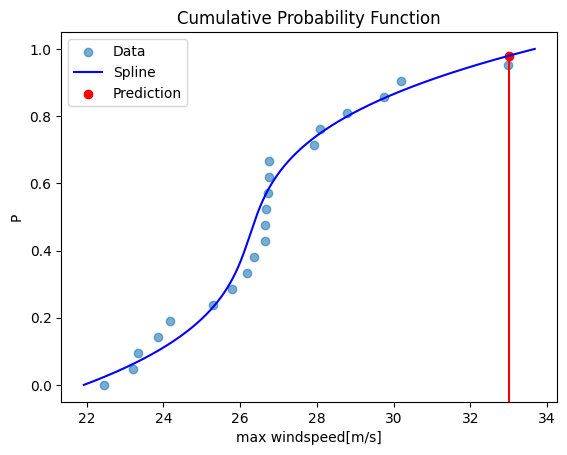

In [77]:
#load the dataset
max_speeds = np.sort(np.load('max-speeds.npy'))
years_nb = max_speeds.shape[0]
cprob = np.arange(years_nb)/years_nb

quantile_func = UnivariateSpline(cprob, max_speeds)

fifty_prob = 1. - 0.02
fifty_wind = quantile_func(fifty_prob)

xs = np.linspace(0, 1, 10**3)
ys = quantile_func(xs)

plt.scatter(max_speeds, cprob, label='Data', alpha=0.6)
plt.plot(ys, xs, color='b', label='Spline')
plt.scatter(fifty_wind, fifty_prob, label='Prediction', color='red')

plt.title("Cumulative Probability Function")
plt.xlabel('max windspeed[m/s]')
plt.ylabel('P')
plt.axvline(fifty_wind, 0, fifty_prob-0.05, linestyle='-', color='red')

plt.legend()
plt.show()

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max: 17, 19, 21, 28, 33, 38, 37, 7, 31, 23, 19, 18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

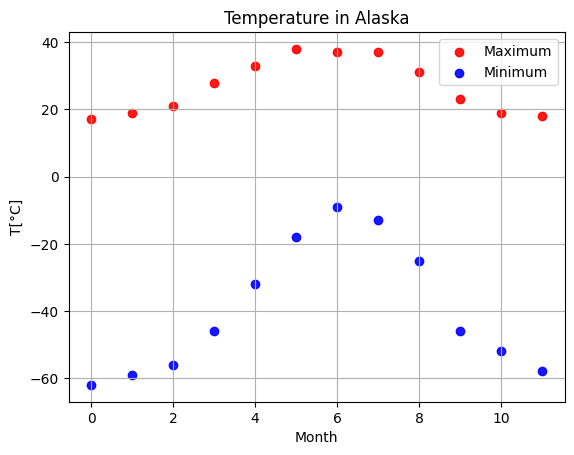

In [78]:
max=np.array([17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18])
min=np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
month = np.arange(12)

plt.scatter(month, max, c='r', alpha=0.9, label="Maximum")
plt.scatter(month, min, c='b', alpha=0.9, label = "Minimum")
plt.title("Temperature in Alaska")
plt.xlabel("Month")
plt.ylabel("T[°C]")
plt.legend()
plt.grid()


I think that a good hypotesis might be a periodic sinusoidal function of the type 

f(x) = A*sin(B*x+C) + D


In [79]:
def fit_func(x, A, B, C, D):
    return A*np.sin(B*x+C) + D

popt_max, pcov_max = curve_fit(fit_func, xdata=month, ydata=max, p0=[20, 0.5, -6, 30])
popt_min, pcov_min = curve_fit(fit_func, xdata=month, ydata=min, p0=[45, 0.5, -6, -40])

print("optimal parameters for the max: ")
print(popt_max)
print("std of the parmeters: ")
print(np.sqrt(np.diag(pcov_max)))
print()

print("optimal parameters for the min: ")
print(popt_min)
print("std of the parmeters: ")
print(np.sqrt(np.diag(pcov_min)))
print()

optimal parameters for the max: 
[10.58169952  0.59227424 -8.10184109 27.9496354 ]
std of the parmeters: 
[0.41007837 0.02118289 0.12602215 0.42824771]

optimal parameters for the min: 
[-25.14962039   0.60132074  -5.25869358 -36.71257093]
std of the parmeters: 
[1.31456201 0.02303728 0.14305076 1.19105171]



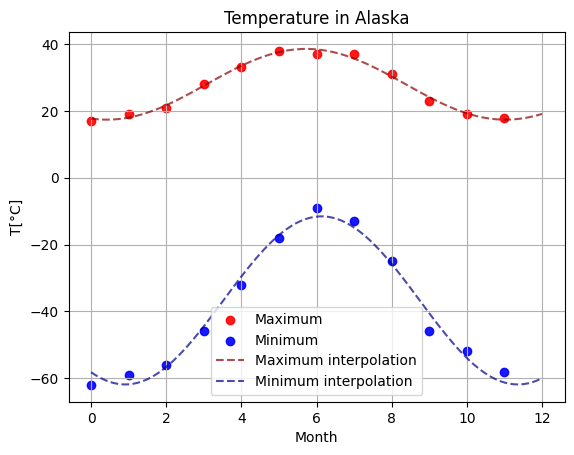

In [80]:
#let's plot the results
x_int = np.linspace(start=0, stop=12, num = 100)
max_pred = fit_func(x_int, *popt_max)
min_pred = fit_func(x_int, *popt_min)

plt.scatter(month, max, c='r', alpha=0.9, label="Maximum")
plt.scatter(month, min, c='b', alpha=0.9, label = "Minimum")
plt.plot(x_int, max_pred, color="darkred", alpha=0.7, linestyle="dashed", label="Maximum interpolation")
plt.plot(x_int, min_pred, color="darkblue", alpha=0.7, linestyle="dashed", label = "Minimum interpolation")

plt.title("Temperature in Alaska")
plt.xlabel("Month")
plt.ylabel("T[°C]")
plt.legend()
plt.grid()


3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


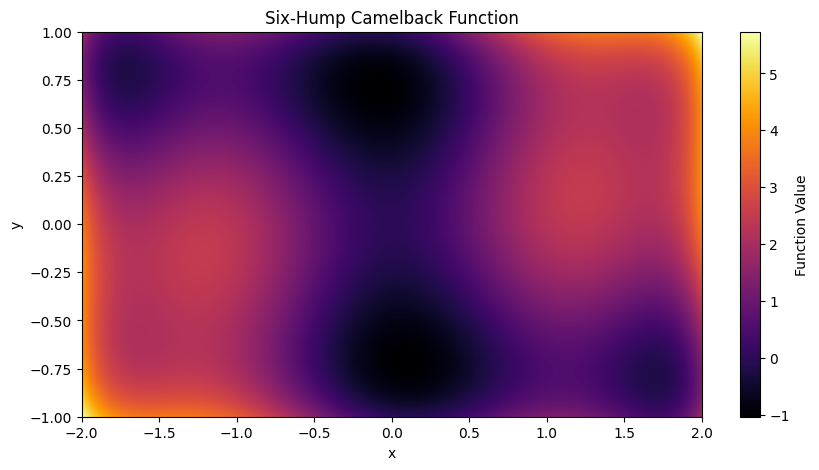

In [81]:
def f(x, y):
    return (4-2.1*(x**2)+(x**4)/3)*(x**2)+x*y+(4*(y**2)-4)*y**2
#Restricting variables
x = np.linspace(-2, 2, 400)
y = np.linspace(-1, 1, 200)

#Plot
x_plot, y_plot = np.meshgrid(x, y)

plt.figure(figsize = (10, 5))
#The defult option for origin is 'upper', which puts the origin in the upper-left corner. That's good for images, but not for graphs e matrixes, so we need to specify origin = 'lower', which puts the origin in the lower-left corner.
plt.imshow(f(x_plot, y_plot), extent = [x.min(), x.max(), y.min(), y.max()], origin = 'lower', cmap = 'inferno', aspect = 'auto')
plt.colorbar(label = 'Function Value')
plt.title('Six-Hump Camelback Function')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

It looks like there are 4 local minima in this region.
2 of them are the global minima since the function is even in both x and y:

f(-x,-y)=f(x,y)

In [82]:
#Defining the object function as required by scipy.optimize.minimize()
def obj(x):
    return f(x[0], x[1])

#Let's divide the plane in two half regions to find the two global minima and verify they have the same value of f
#I initialize the algorith in two points visually close to the minimum
upper_bounds = [(-2, 2), (0, 1)]
upper_minimum = minimize(obj, (0, 0.7), bounds = upper_bounds)

lower_bounds = [(-2, 2), (-1, 0)]
lower_minimum = minimize(obj, (0, -0.7), bounds = lower_bounds)

print(f'Minimum in the upper region: f({upper_minimum.x[0]:.3f}, {upper_minimum.x[1]:.3f}) = {upper_minimum.fun}')
print(f'Minimum in the lower region: f({lower_minimum.x[0]:.3f}, {lower_minimum.x[1]:.3f}) = {lower_minimum.fun}')


Minimum in the upper region: f(-0.090, 0.713) = -1.0316284534898756
Minimum in the lower region: f(0.090, -0.713) = -1.031628453489877


4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

Shape:  (474, 630)
Mimimum:  0.090098776
Maximum:  126598.46


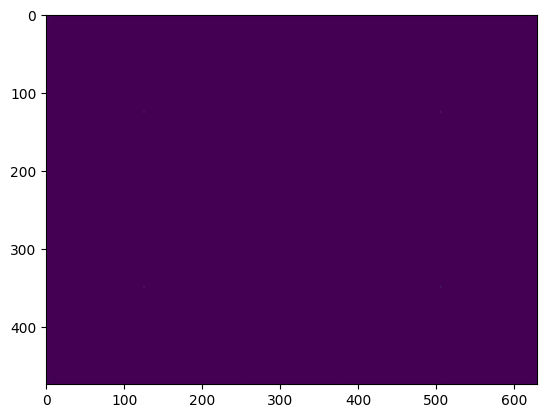

In [83]:
img =  plt.imread(fname="./moonlanding.png")
print("Shape: ", img.shape)
freq = fft2(img)
spectrum = abs(freq)
print("Mimimum: ", np.min(spectrum))
print("Maximum: ", np.max(spectrum))

plt.imshow(spectrum)


We can't actually visualize the spectrum because the values can take a wide range. We have to apply a transformation. In this case I'll try with the log(freq+1)

Text(0.5, 1.0, 'Spectrum')

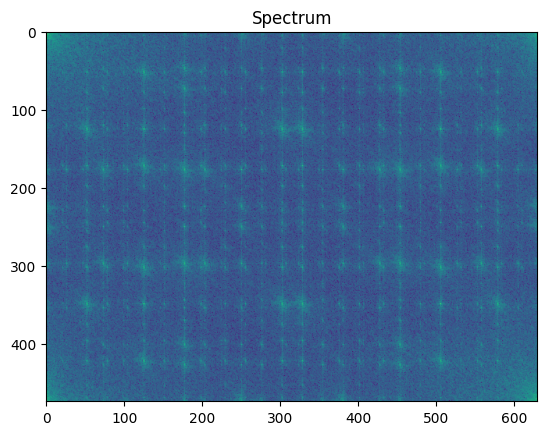

In [84]:
plt.imshow(np.log(spectrum+1))
plt.title("Spectrum")

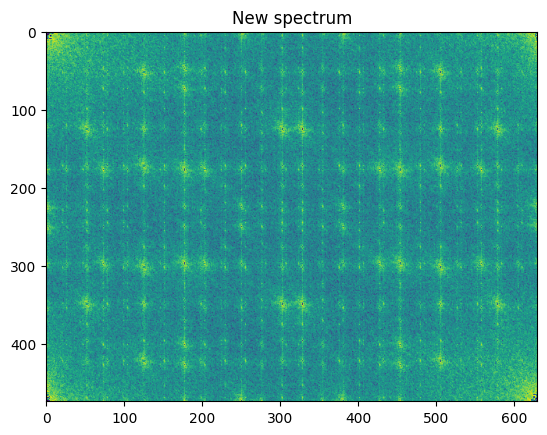

In [85]:
#let's remove the high frequency noise
#All values above a certain value are set to zero
threshold = 0.008
freq[spectrum > (threshold * np.max(spectrum))] = 0
spectrum = np.abs(freq)

#Plot of new spectrum
plt.imshow(np.log(spectrum+1))
plt.title('New spectrum')
plt.show()

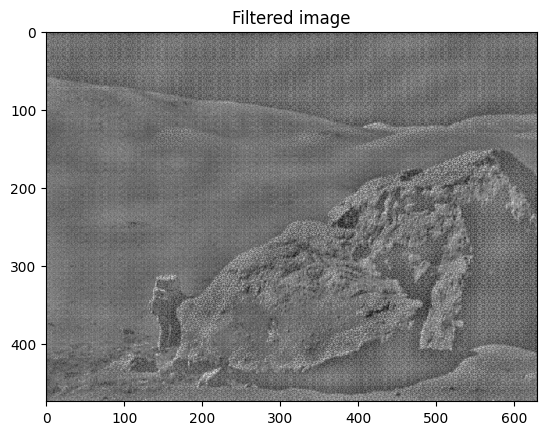

In [86]:
#Inverse fourier transform
img_filtered = ifft2(freq).real   

#Plot of filtered image
plt.imshow(img_filtered, cmap = 'gray')
plt.title('Filtered image')
plt.show()